# Import Required Repositories

In [ ]:
!pip install langdetect
!pip install pandas==1.3

In [ ]:

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import langdetect
import string
import scipy
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

# Movie Data Loading

In [ ]:
# Set data directory
DRIVE_ROOT = '/content/drive'
DATA_DIRECTORY = '/My Drive/CS-UA480'

In [ ]:
# Get data from google drive
from google.colab import drive
drive.mount(DRIVE_ROOT) 

Mounted at /content/drive


In [ ]:
# Prepare for reading the orginal data in the format of JSONarray
def JsonParser(data):
  data = data.replace("'", '"')
  j = json.loads(data)
  return j

In [ ]:
# Load the csv file as dataframe
df_full = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/movies_metadata.csv', converters={'genres':JsonParser})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_full.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
df_full.shape

(45466, 24)

# Data Preprocessing

We are only using title, genres, and overview columns in our project. Also, we want to select movies only in English.

In [ ]:
# The columns used in the future
df = df_full[df_full['original_language']=='en'][['title','genres','overview']]

In [ ]:
df.head()

,title,genres,overview
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...


In [ ]:
# Language Selection
def detect_default(overview):
  try:
    return langdetect.detect(overview)
  except:
    return 'error'

In [ ]:
overview_lan = df['overview'].astype('str').apply(detect_default)

In [ ]:
# filter only English Overview
df = df[overview_lan=='en']

In [ ]:
df.isnull().sum()

title       2
genres      0
overview    0
dtype: int64

There is some invalid data in the dataset. We would abandon the data with missing features.  

In [ ]:
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
df.shape

(32081, 3)

In [ ]:
(df['genres'].str.len()==0).sum()

1627

There are more than 1600 rows of data without being assigned with a genre. We will drop them at moment.

In [ ]:
df.drop(df[df['genres'].str.len()==0].index, inplace=True)

In [ ]:
df.shape

(30454, 3)

In [ ]:
df.head()

,title,genres,overview
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...


Now we take a look at the number of genres each movie falls in. \\
For convinience of processing the data, we flatten our 'genres' column.

In [ ]:
def flatten_genres(genres):
  return [genre_info['name'] for genre_info in genres]

In [ ]:
df['genres'] = df['genres'].map(flatten_genres)

In [ ]:
df.head()

,title,genres,overview
0,Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...


In [ ]:
genres_length = df['genres'].str.len()

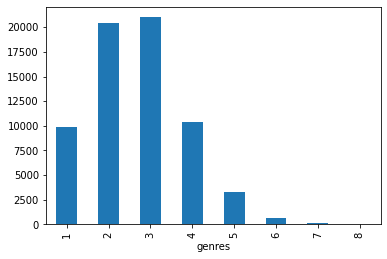

In [ ]:
genres_length.groupby(genres_length).sum().plot(kind='bar')

We can see that all movies in the remaining dataset fall in 1 to 8 genres. 

In [ ]:
overview_length = df['overview'].str.len()

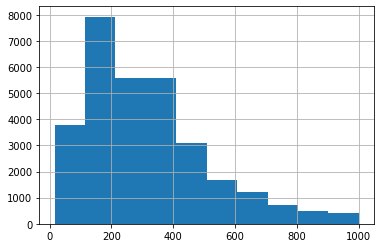

In [ ]:
overview_length.hist()

In [ ]:
df.shape

(30454, 3)

## Split data into training, testing, validation sets

In [ ]:
# 0.15 for val, 0.15 for test, 0.7 for train
train_df, val_data = train_test_split(df, test_size = 0.3)
val_df, test_df = train_test_split(val_data, test_size = 0.5)
train_texts, train_labels = list(train_df.overview), list(train_df.genres)
val_texts, val_labels     = list(val_df.overview), list(val_df.genres)
test_texts, test_labels   = list(test_df.overview), list(test_df.genres)

# val_size = int(df.shape[0] * 0.15)
# test_size = int(df.shape[0] * 0.15)
# Shuffle the data
# df = df.sample(frac=1)
# # Split df to test/val/train
# test_df = df[:test_size]
# val_df = df[test_size:test_size+val_size]
# train_df = df[test_size+val_size:]

# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 30454
Train size: 21317
Val size: 4568
Test size: 4569



In [ ]:
train_labels[:10]

[['Documentary'],
 ['Western'],
 ['Adventure', 'Action', 'Comedy'],
 ['Adventure', 'Science Fiction'],
 ['Crime', 'Drama', 'Thriller'],
 ['Comedy'],
 ['Action', 'Crime', 'Drama'],
 ['Thriller', 'Drama'],
 ['Comedy', 'Mystery'],
 ['Adventure', 'Fantasy', 'Action', 'Drama']]

## Transform Labels (Genres)

In [ ]:
# Using the MultiLabelBinarizer class
mb = MultiLabelBinarizer()

In [ ]:
train_labels_transformed = mb.fit_transform(train_labels)

In [ ]:
train_labels_transformed[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
val_labels_transformed = mb.transform(val_labels)

In [ ]:
val_labels_transformed[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_labels_transformed = mb.transform(test_labels)

In [ ]:
test_labels_transformed[0]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
mb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [ ]:
# Convert all the classes into column list for future convenience
column = []
for item in mb.classes_:
  column.append(item)

print(column)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


# Save Preprocessed data to a Permanent csv file

In [ ]:
# Drop the original textual genres and reset the index
test_df = test_df.drop(columns='genres')
test_df.reset_index(drop = True, inplace =True)
val_df = val_df.drop(columns='genres')
val_df.reset_index(drop = True, inplace =True)
train_df = train_df.drop(columns='genres')
train_df.reset_index(drop = True, inplace =True)

In [ ]:
# Create dataframe for the transformed genres and reset the index
train_labels = pd.DataFrame(train_labels_transformed, columns = column)
train_labels.reset_index(drop = True, inplace =True)
val_labels = pd.DataFrame(val_labels_transformed, columns = column)
val_labels.reset_index(drop = True, inplace =True)
test_labels = pd.DataFrame(test_labels_transformed, columns = column)
test_labels.reset_index(drop = True, inplace =True)

In [ ]:
# Merge two dataframe to create our final data
test = pd.concat([test_df, test_labels], axis=1, ignore_index = True)
val = pd.concat([val_df, val_labels], axis=1, ignore_index = True)
train = pd.concat([train_df, train_labels], axis=1, ignore_index = True)

In [ ]:
# Change the column name
train.columns = ['title','overview'] + column
val.columns = ['title','overview'] + column
test.columns = ['title','overview'] + column

In [ ]:
train

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Bruce Lee: The Legend,The Official Golden Harvest tribute to the Mas...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True Grit,The murder of her father sends a teenage tombo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,If Looks Could Kill,"Michael Corben, along with the rest of his hig...",1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The 5th Wave,16-year-old Cassie Sullivan tries to survive i...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Nick of Time,Gene Watson is a public accountant who arrives...,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21312,The Doctor and the Devils,Grave robbers supply a doctor with bodies to t...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
21313,Atlantic City,"Lou (Burt Lancaster), a small time gangster wh...",0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
21314,They're Playing with Fire,A married college professor decides to seduce ...,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
21315,Out of the Dark,A couple and their daughter moves to Colombia ...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
# # Create csv files based on our dataframe
# test.to_csv('/content/drive/My Drive/CS-UA480/Data/test.csv', index = False)
# val.to_csv('/content/drive/My Drive/CS-UA480/Data/val.csv', index = False)
# train.to_csv('/content/drive/My Drive/CS-UA480/Data/train.csv', index = False)